In [1]:
import torch

from mpc import mpc
from mpc.mpc import QuadCost, LinDx, GradMethods
from mpc.env_dx import hri

import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt

import os
import io
import base64
import tempfile
from IPython.display import HTML

from tqdm import tqdm

%matplotlib inline

In [14]:
from mpc.env_dx import hri

# Dempster et al. model from @Hwang2015
# For a subject
# - weight = 75 kg
# - thigh length = 0.4 m
# - shank length = 0.4 m

params = {
            "m1": 7.275,
            "m2": 3.75,
            "m3": 2,
            "m4": 2,
            "g": 0,
            "I_G1z": 0.121*1e6,
            "I_G2z": 0.055*1e6,
            "I_G3z": 0.02*1e6,
            "I_G4z": 0.02*1e6,
            "l1": 0.4*1e3,
            "l2": 0.4*1e3,
            "l3": 0.2*1e3,
            "l4": 0.2*1e3,
            "lc1": 0.173*1e3,
            "la1": 0.2*1e3,
            "lb1": 0.05*1e3,
            "lc2": 0.173*1e3,
            "lc3": 0.1*1e3,
            "lc4": 0.1*1e3,
            "la4": 0.2*1e3,
            "la2": 0.2*1e3,
            "K_AFz": 60000*1e-3,
            "K_AFx": 30000*1e-3,
            "K_AMy": 50*1e3,
            "K_BFz": 60000*1e-3,
            "K_BFx": 30000*1e-3,
            "K_BMy": 50*1e3,
        }

# params = {
#             "m1": 1,
#             "m2": 1,
#             "m3": 1,
#             "m4": 1,
#             "g": 0,
#             "I_G1z": 1,
#             "I_G2z": 1,
#             "I_G3z": 1,
#             "I_G4z": 1,
#             "l1": 1,
#             "l2": 1,
#             "l3": 0.8,
#             "l4": 0.8,
#             "lc1": 0.5,
#             "la1": 0.2,
#             "lb1": 0.2,
#             "lc2": 0.5,
#             "lc3": 0.4,
#             "lc4": 0.4,
#             "la4": 0.3,
#             "la2": 0.3,
#             "K_AFz": 50,
#             "K_AFx": 50,
#             "K_AMy": 20,
#             "K_BFz": 50,
#             "K_BFx": 50,
#             "K_BMy": 20,
#         }

n_batch, T, mpc_T = 1, 60, 5

dx = hri.HRIDx(model_params=params, simple=True)

def uniform(shape, low, high):
    r = high-low
    return torch.rand(shape)*r+low

torch.manual_seed(0)
h_q2 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
r_d2 = uniform(n_batch, 0., 0.)
r_d3 = uniform(n_batch, 0., 0.)
r_q4 = uniform(n_batch, 0., 0.)
r_q5 = uniform(n_batch, -0.5*np.pi, -0.5*np.pi)
h_dq2 = uniform(n_batch, 0., 0.)
r_dd2 = uniform(n_batch, 0., 0.)
r_dd3 = uniform(n_batch, 0., 0.)
r_dq4 = uniform(n_batch, 0., 0.)
r_dq5 = uniform(n_batch, 0., 0.)

# fix
xinit = torch.stack((h_q2, h_dq2, r_d2, r_dd2, r_d3, r_dd3, r_q4, r_dq4, r_q5, r_dq5), dim=1)

x = xinit
u_init = None

# The cost terms for the swingup task can be alternatively obtained
# for this pendulum environment with:
# q, p = dx.get_true_obj()

mode = 'swingup'
# mode = 'spin'

if mode == 'swingup':
    des_angle = 0.5*np.pi
    goal_weights = torch.Tensor((100., 0., 0., 0., 0., 0., 0., 0., 0., 0.))
    goal_state = torch.Tensor((des_angle, 0., 0., 0., 0. , 0., 0. ,0., des_angle, 0.))
    ctrl_penalty = 0.00001
    q = torch.cat((
        goal_weights,
        ctrl_penalty*torch.ones(dx.n_ctrl)
    ))
    px = -torch.sqrt(goal_weights)*goal_state
    p = torch.cat((px, torch.zeros(dx.n_ctrl)))
    Q = torch.diag(q).unsqueeze(0).unsqueeze(0).repeat(
        mpc_T, n_batch, 1, 1
    )
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)
elif mode == 'spin':
    Q = 0.001*torch.eye(dx.n_state+dx.n_ctrl).unsqueeze(0).unsqueeze(0).repeat(
        mpc_T, n_batch, 1, 1
    )
    p = torch.tensor((0., 0., -1., 0.))
    p = p.unsqueeze(0).repeat(mpc_T, n_batch, 1)

t_dir = tempfile.mkdtemp()
print('Tmp dir: {}'.format(t_dir))

# initialise an array to store the state and action trajectories
x_traj = torch.zeros(T, dx.n_state)
u_traj = torch.zeros(T, dx.n_ctrl)

for t in tqdm(range(T)):
    nominal_states, nominal_actions, nominal_objs = mpc.MPC(
        dx.n_state, dx.n_ctrl, mpc_T,
        u_init=u_init,
        u_lower=dx.lower, u_upper=dx.upper,
        lqr_iter=50,
        verbose=0,
        exit_unconverged=False,
        detach_unconverged=False,
        linesearch_decay=dx.linesearch_decay,
        max_linesearch_iter=dx.max_linesearch_iter,
        grad_method=GradMethods.FINITE_DIFF,
        eps=1e-2,
    )(x, QuadCost(Q, p), dx)
    
    # shift the actions one step forward as the initial guess for the next step
    next_action = nominal_actions[0]
    u_init = torch.cat((nominal_actions[1:], torch.zeros(1, n_batch, dx.n_ctrl)), dim=0)
    u_init[-2] = u_init[-3]  # no idea what this does
    x = dx(x, next_action)
    
    # save the state and action trajectories
    x_traj[t] = x
    u_traj[t] = next_action

    #fig.savefig(os.path.join(t_dir, '{:03d}.png'.format(t)))
    #plt.close(fig)

Tmp dir: /var/folders/ch/glb2rc_j5bzc2h7ggs8xj_w40000gp/T/tmplq8kabst


100%|██████████| 100/100 [43:08<00:00, 25.88s/it]


tensor([-1.5708, -1.5708, -1.5708, -1.5708, -1.5707, -1.5707, -1.5706, -1.5706,
        -1.5705, -1.5705, -1.5704, -1.5703, -1.5702, -1.5701, -1.5700, -1.5699,
        -1.5698, -1.5697, -1.5695, -1.5694, -1.5692, -1.5691, -1.5689, -1.5688,
        -1.5686, -1.5685, -1.5683, -1.5681, -1.5680, -1.5678, -1.5676, -1.5674,
        -1.5673, -1.5671, -1.5669, -1.5667, -1.5665, -1.5664, -1.5662, -1.5660,
        -1.5658, -1.5657, -1.5655, -1.5653, -1.5652, -1.5650, -1.5648, -1.5647,
        -1.5645, -1.5644, -1.5642, -1.5641, -1.5640, -1.5638, -1.5637, -1.5636,
        -1.5635, -1.5633, -1.5632, -1.5631, -1.5630, -1.5629, -1.5629, -1.5628,
        -1.5627, -1.5626, -1.5625, -1.5625, -1.5624, -1.5623, -1.5623, -1.5622,
        -1.5622, -1.5621, -1.5621, -1.5620, -1.5620, -1.5619, -1.5619, -1.5619,
        -1.5618, -1.5618, -1.5617, -1.5617, -1.5617, -1.5616, -1.5616, -1.5615,
        -1.5615, -1.5614, -1.5614, -1.5613, -1.5613, -1.5612, -1.5611, -1.5610,
        -1.5610, -1.5609, -1.5608, -1.56

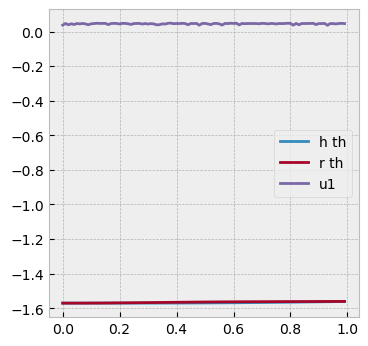

In [12]:
axs = plt.figure(figsize=(4,4))
# print x_traj values
print(x_traj[:, 8])

# create an array for the time steps
t = np.arange(T) / 100  # defined in hri.py, dt = 0.05
for i in range(n_batch):
    plt.plot(t, x_traj[:, 0])
    plt.plot(t, x_traj[:, 8])
    plt.plot(t, u_traj[:, 0].detach().numpy())
    plt.legend(['h th', 'r th', 'u1'])
plt.show()

In [ ]:
vid_fname = 'pendulum-{}.mp4'.format(mode)

if os.path.exists(vid_fname):
    os.remove(vid_fname)
    
cmd = 'ffmpeg -r 16 -f image2 -i {}/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(
    t_dir, vid_fname
)

os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [4]:
a = torch.tensor([20., 30., 40., 50., 60., 70., 80., 90., 100., 110.])
a[-3]

tensor(90.)